#TESLA Stock Sentiment Prediction NLP Project

#BUILDING THE GRAPH OF ENTITIES WITH ASSIGNED WEIGHTS

In [1]:
# ============================================
# 0. Mounting Google Drive and defining folders
# ============================================

from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path


# Project root in Drive.

BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/NLP")

# Shared folder that all outputs will go to.
SHARED_DIR = BASE_DIR / "NLP Project Shared"
SHARED_DIR.mkdir(parents=True, exist_ok=True)

print("Base project dir:", BASE_DIR)
print("Shared project dir:", SHARED_DIR)


Mounted at /content/drive
Base project dir: /content/drive/MyDrive/Colab Notebooks/NLP
Shared project dir: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared


## 1. Data loading

All datasets used in this project were stored in a shared Google Drive folder to ensure consistent access across all collaborators.
The analysis combined information from several complementary sources.
The files tesla_gdelt_2025.csv and elon_related_2025.csv were extracted from the GDELT database and contain global news articles filtered by keywords related to Tesla and Elon Musk.
In addition, three files generated during the named entity recognition (NER) stage were used: entities_per_url.csv, entities_summary.csv, and url_metadata.csv.
The first of these lists every entity identified in each article, along with its frequency and label (e.g., PERSON, ORGANIZATION, or LOCATION).
The second file aggregates the overall frequencies of all entities across the entire corpus, while the metadata file includes general information about each article, such as its title and publication domain.
These datasets were read into Python using pandas and provided the foundation for the subsequent construction of the entity co-occurrence graphs.

## Overwrite the original files with the 2025-only versions

In [2]:
import pandas as pd
from pathlib import Path

BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
SHARED_DIR = BASE_DIR / "NLP Project Shared"

TESLA_GDELT_PATH = SHARED_DIR / "tesla_gdelt_2025.csv"
ELON_GDELT_PATH  = SHARED_DIR / "elon_related_2025.csv"

# 1. Load the current files (all years).
tesla_full = pd.read_csv(TESLA_GDELT_PATH)
elon_full  = pd.read_csv(ELON_GDELT_PATH)

print("Original tesla_gdelt rows:", tesla_full.shape[0])
print("Original elon_gdelt rows :", elon_full.shape[0])

# 2. Save backups with *_full names (only if they do not already exist).
tesla_backup = SHARED_DIR / "tesla_gdelt_full.csv"
elon_backup  = SHARED_DIR / "elon_related_full.csv"

if not tesla_backup.exists():
    tesla_full.to_csv(tesla_backup, index=False)
    print("Backup written:", tesla_backup)
else:
    print("Backup already exists:", tesla_backup)

if not elon_backup.exists():
    elon_full.to_csv(elon_backup, index=False)
    print("Backup written:", elon_backup)
else:
    print("Backup already exists:", elon_backup)

# 3. Filter to year 2025 only.
tesla_2025 = tesla_full[tesla_full["SQLDATE"].astype(str).str.startswith("2025")].copy()
elon_2025  = elon_full[elon_full["SQLDATE"].astype(str).str.startswith("2025")].copy()

print("Filtered tesla_gdelt 2025:", tesla_2025["SQLDATE"].min(), "to", tesla_2025["SQLDATE"].max(),
      "| rows:", tesla_2025.shape[0])
print("Filtered elon_gdelt  2025:", elon_2025["SQLDATE"].min(), "to", elon_2025["SQLDATE"].max(),
      "| rows:", elon_2025.shape[0])

# 4. Overwrite the original files with the 2025-only versions.
tesla_2025.to_csv(TESLA_GDELT_PATH, index=False)
elon_2025.to_csv(ELON_GDELT_PATH, index=False)
print("Overwritten original CSVs with 2025-only data.")


Original tesla_gdelt rows: 43114
Original elon_gdelt rows : 232450
Backup already exists: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/tesla_gdelt_full.csv
Backup already exists: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/elon_related_full.csv
Filtered tesla_gdelt 2025: 20250101 to 20251008 | rows: 43114
Filtered elon_gdelt  2025: 20250101 to 20251008 | rows: 232450
Overwritten original CSVs with 2025-only data.


In [3]:
# ============================================
# 1. Data loading
# ============================================

import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from itertools import combinations
import re
import networkx as nx
from pathlib import Path

# Base paths
BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
SHARED_DIR = BASE_DIR / "NLP Project Shared"

# Input files
ENT_PER_URL_PATH = SHARED_DIR / "entities_per_url.csv"
ENT_SUMMARY_PATH = SHARED_DIR / "entities_summary.csv"
META_PATH        = SHARED_DIR / "url_metadata.csv"
TESLA_GDELT_PATH = SHARED_DIR / "tesla_gdelt_2025.csv"      # now already 2025-only
ELON_GDELT_PATH  = SHARED_DIR / "elon_related_2025.csv"     # now already 2025-only

# Load the main tables
ents_per_url = pd.read_csv(ENT_PER_URL_PATH)
ents_summary = pd.read_csv(ENT_SUMMARY_PATH)
url_meta     = pd.read_csv(META_PATH)
tesla_gdelt  = pd.read_csv(TESLA_GDELT_PATH)
elon_gdelt   = pd.read_csv(ELON_GDELT_PATH)

print("ents_per_url:", ents_per_url.shape)
print("ents_summary:", ents_summary.shape)
print("url_meta:", url_meta.shape)

print("tesla_gdelt rows:", tesla_gdelt.shape[0],
      "| period:", tesla_gdelt["SQLDATE"].min(), "to", tesla_gdelt["SQLDATE"].max())
print("elon_gdelt  rows:", elon_gdelt.shape[0],
      "| period:", elon_gdelt["SQLDATE"].min(), "to", elon_gdelt["SQLDATE"].max())


ents_per_url: (1321161, 6)
ents_summary: (500762, 5)
url_meta: (53465, 4)
tesla_gdelt rows: 43114 | period: 20250101 to 20251008
elon_gdelt  rows: 232450 | period: 20250101 to 20251008


In [4]:

# ============================================
# 1. Data loading
# ============================================

import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from itertools import combinations
import re
import networkx as nx
from pathlib import Path

# Base paths
BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
SHARED_DIR = BASE_DIR / "NLP Project Shared"

# Input files
ENT_PER_URL_PATH = SHARED_DIR / "entities_per_url.csv"
ENT_SUMMARY_PATH = SHARED_DIR / "entities_summary.csv"
META_PATH        = SHARED_DIR / "url_metadata.csv"
TESLA_GDELT_PATH = SHARED_DIR / "tesla_gdelt_2025.csv"      # now already 2025-only
ELON_GDELT_PATH  = SHARED_DIR / "elon_related_2025.csv"     # now already 2025-only

# Load the main tables
ents_per_url = pd.read_csv(ENT_PER_URL_PATH)
ents_summary = pd.read_csv(ENT_SUMMARY_PATH)
url_meta     = pd.read_csv(META_PATH)
tesla_gdelt  = pd.read_csv(TESLA_GDELT_PATH)
elon_gdelt   = pd.read_csv(ELON_GDELT_PATH)

print("ents_per_url:", ents_per_url.shape)
print("ents_summary:", ents_summary.shape)
print("url_meta:", url_meta.shape)

print("tesla_gdelt rows:", tesla_gdelt.shape[0],
      "| period:", tesla_gdelt["SQLDATE"].min(), "to", tesla_gdelt["SQLDATE"].max())
print("elon_gdelt  rows:", elon_gdelt.shape[0],
      "| period:", elon_gdelt["SQLDATE"].min(), "to", elon_gdelt["SQLDATE"].max())


ents_per_url: (1321161, 6)
ents_summary: (500762, 5)
url_meta: (53465, 4)
tesla_gdelt rows: 43114 | period: 20250101 to 20251008
elon_gdelt  rows: 232450 | period: 20250101 to 20251008


##2. URL -> date mapping

Each article was associated with its publication date by merging the URLs found in the GDELT files with those in the NER output.
A dictionary (url2date) was created where each key corresponds to a unique URL and each value stores its date (SQLDATE).
This mapping enabled the chronological organization of articles, which was required for creating time-based entity batches.

In [5]:
# ============================================
# 2. URL -> date mapping
# ============================================

# The two GDELT datasets are combined so that a single mapping from SOURCEURL to SQLDATE is created.
gdelt_urls = pd.concat(
    [
        tesla_gdelt[["SQLDATE", "SOURCEURL"]],
        elon_gdelt[["SQLDATE", "SOURCEURL"]],
    ],
    ignore_index=True,
)

# Duplicate URLs are removed so that each URL is mapped to one date only.
gdelt_urls = gdelt_urls.drop_duplicates(subset=["SOURCEURL"])

# A dictionary from URL to date is created for fast lookup.
url2date = gdelt_urls.set_index("SOURCEURL")["SQLDATE"].to_dict()

print("unique urls with dates:", len(url2date))


unique urls with dates: 69315


## 3. Normalization utilities

Light normalization was applied to reduce duplicate or variant entity forms while preserving named-entity integrity.
The following operations were carried out:

Conversion of entity text to lowercase.

Removal of possessive endings (e.g., “Musk’s” → “Musk”).

Removal of punctuation and extra spaces.

Manual canonicalization using a predefined dictionary (e.g., “Musk” → “Elon Musk”, “Tesla Inc.” → “Tesla”).

Common spaCy labels that do not contribute to semantic analysis (such as DATE, TIME, CARDINAL, MONEY, etc.) were removed.
Very short entities were also excluded unless they represented relevant short forms (e.g., “US”, “UK”, “EU”).
This step ensured that different surface forms of the same real-world entity were treated as one and that noise was minimized.

In [6]:
# ============================================
# 3. Normalization utilities
# ============================================

BAD_LABELS = {
    "DATE",
    "TIME",
    "CARDINAL",
    "ORDINAL",
    "PERCENT",
    "QUANTITY",
    "MONEY",
    "LANGUAGE",
}

WHITELIST_SHORT = {"us", "uk", "eu", "uae", "ny"}

CANON_MAP = {
    "tesla inc": "tesla",
    "tesla, inc": "tesla",
    "tesla motors": "tesla",
    "teslas":"tesla",
    "elon musk": "elon musk",
    "donald trump":"trump",
    "musk": "elon musk",
    "elon":"elon musk",
    "the department of government efficiency":"department of government efficiency",
    "x corp": "x",
    "x corp.": "x",
    # common country/name variants
    "u s": "u.s.",
    "u.s": "u.s.",
    "u.s.": "u.s.",
    "the united states": "u.s.",
    "america":"u.s.",

}

import re

def normalize_ent(text: str) -> str:
    """
    A light entity normalization is applied.
    The goal is to reduce obvious duplicates without damaging named entities.
    """
    text = str(text)
    text = text.lower()
    # Possessive endings are removed.
    text = text.replace("’s", "").replace("'s", "")
    # Only letters, digits and spaces are kept.
    text = re.sub(r"[^a-z0-9]+", " ", text)
    # Multiple spaces are collapsed.
    text = re.sub(r"\s+", " ", text).strip()
    # Known variants are canonicalized.
    if text in CANON_MAP:
        return CANON_MAP[text]
    return text


## 4. Cleaning of entities_per_url

In [7]:
# ============================================
# 4. Cleaning per-URL entities
# ============================================

# Each entity row is given a date from the GDELT mapping.
ents_per_url["SQLDATE"] = ents_per_url["SOURCEURL"].map(url2date)

# Rows without a date are removed.
ents_per_url = ents_per_url.dropna(subset=["SQLDATE"]).copy()

# Entity text is normalized.
ents_per_url["norm_ent"] = ents_per_url["entity"].apply(normalize_ent)

# Unwanted labels are removed.
ents_per_url = ents_per_url[~ents_per_url["label"].isin(BAD_LABELS)].copy()

# Very short items are removed unless they are whitelisted.
short_mask = ents_per_url["norm_ent"].str.len() < 3
keep_mask  = ents_per_url["norm_ent"].isin(WHITELIST_SHORT)
ents_per_url = ents_per_url[~(short_mask & ~keep_mask)].copy()

print("after cleaning:", ents_per_url.shape)


after cleaning: (1302502, 8)


##4.1 Download 2025 articles per day and build index

The following code has been ran and managed to create up to the 20210922 file in the articles_2025_by_day

In [ ]:
# # ============================================
# # A. Download 2025 articles per day and index them
# # ============================================
# import hashlib
# import requests
# import time

# ARTICLES_DIR_2025 = SHARED_DIR / "articles_2025_by_day"
# ARTICLES_DIR_2025.mkdir(parents=True, exist_ok=True)

# # combined GDELT for 2025, deduplicated by URL
# gd_2025 = (
#     pd.concat(
#         [
#             tesla_gdelt[["SQLDATE", "SOURCEURL"]],
#             elon_gdelt[["SQLDATE", "SOURCEURL"]],
#         ],
#         ignore_index=True
#     )
#     .dropna(subset=["SQLDATE", "SOURCEURL"])
#     .drop_duplicates(subset=["SOURCEURL"])
# )
# gd_2025["SQLDATE"] = gd_2025["SQLDATE"].astype(str)

# def fetch_text(url: str, timeout: int = 15) -> str:
#     """
#     A light article downloader.
#     If we already have a better HTML-to-text function, we can plug it in here.
#     """
#     try:
#         r = requests.get(url, timeout=timeout, headers={"User-Agent": "Mozilla/5.0"})
#         if not r.ok:
#             return ""
#         return r.text
#     except Exception:
#         return ""

# art_rows = []

# for row in gd_2025.itertuples(index=False):
#     day = row.SQLDATE
#     url = row.SOURCEURL

#     text = fetch_text(url)
#     if not text or len(text) < 500:
#         continue

#     day_dir = ARTICLES_DIR_2025 / day
#     day_dir.mkdir(exist_ok=True)

#     fname = hashlib.md5(url.encode("utf-8")).hexdigest() + ".txt"
#     fpath = day_dir / fname
#     with open(fpath, "w", encoding="utf-8") as f:
#         f.write(text)

#     art_rows.append({"SQLDATE": day, "SOURCEURL": url, "local_path": str(fpath)})

#     time.sleep(0.3)  # polite delay

# articles_index_2025 = pd.DataFrame(art_rows)
# articles_index_2025.to_csv(SHARED_DIR / "articles_index_2025.csv", index=False)
# print("Articles downloaded and indexed for 2025:", len(articles_index_2025))


Remove the 20250923 folder from the articles_2025_by_day folder so that it can be safely recreated

In [ ]:
# import pandas as pd
# from pathlib import Path

# BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
# SHARED_DIR = BASE_DIR / "NLP Project Shared"
# index_path = SHARED_DIR / "articles_index_2025.csv"

# if not index_path.exists():
#     print("Index file does not exist yet, nothing to clean.")
# else:
#     idx = pd.read_csv(index_path)
#     idx["SQLDATE"] = idx["SQLDATE"].astype(str)

#     print("Index size before:", idx.shape)

#     # rows from 23 September 2025 are removed
#     mask = idx["SQLDATE"] != "20250923"
#     idx_clean = idx[mask].copy()

#     print("Index size after:", idx_clean.shape)
#     print("Rows removed for 20250923:", (idx.shape[0] - idx_clean.shape[0]))

#     idx_clean.to_csv(index_path, index=False)
#     print("Cleaned index saved back to:", index_path)


Index file does not exist yet, nothing to clean.


In [ ]:
# import shutil
# from pathlib import Path

# BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
# SHARED_DIR = BASE_DIR / "NLP Project Shared"

# ARTICLES_DIR_2025 = SHARED_DIR / "articles_2025_by_day"
# day_dir = ARTICLES_DIR_2025 / "20250923"

# if day_dir.exists():
#     shutil.rmtree(day_dir)
#     print("Deleted folder:", day_dir)
# else:
#     print("Folder did not exist:", day_dir)


Deleted folder: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/articles_2025_by_day/20250923


## Resume-safe download of 2025 articles and index from 20250923 onwards

In [ ]:
# ============================================
# Resume-safe 2025 downloader + index builder
# (uses existing files; only downloads missing ones)
# ============================================
import hashlib
import requests
import time
import pandas as pd
from pathlib import Path

BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
SHARED_DIR = BASE_DIR / "NLP Project Shared"

ARTICLES_DIR_2025 = SHARED_DIR / "articles_2025_by_day"
ARTICLES_DIR_2025.mkdir(parents=True, exist_ok=True)

# 1) Load GDELT subset for 2025
tesla_gdelt = pd.read_csv(SHARED_DIR / "tesla_gdelt_2025.csv")
elon_gdelt  = pd.read_csv(SHARED_DIR / "elon_related_2025.csv")

gd_2025 = (
    pd.concat(
        [
            tesla_gdelt[["SQLDATE", "SOURCEURL"]],
            elon_gdelt[["SQLDATE", "SOURCEURL"]],
        ],
        ignore_index=True,
    )
    .dropna(subset=["SQLDATE", "SOURCEURL"])
    .drop_duplicates(subset=["SOURCEURL"])
)
gd_2025["SQLDATE"] = gd_2025["SQLDATE"].astype(str)

index_path = SHARED_DIR / "articles_index_2025.csv"

def fetch_text(url: str, timeout: int = 15) -> str:
    """Basic HTML fetcher; can be replaced with a better extractor."""
    try:
        r = requests.get(url, timeout=timeout, headers={"User-Agent": "Mozilla/5.0"})
        if not r.ok:
            return ""
        return r.text
    except Exception:
        return ""

rows = []
downloaded = 0
skipped_existing = 0

for row in gd_2025.itertuples(index=False):
    day = row.SQLDATE
    url = row.SOURCEURL

    day_dir = ARTICLES_DIR_2025 / day
    day_dir.mkdir(exist_ok=True)

    # Deterministic file name from URL
    fname = hashlib.md5(url.encode("utf-8")).hexdigest() + ".txt"
    fpath = day_dir / fname

    if fpath.exists():
        # File already stored: no download, but index entry is added
        skipped_existing += 1
        rows.append(
            {
                "SQLDATE": day,
                "SOURCEURL": url,
                "local_path": str(fpath),
            }
        )
        continue

    text = fetch_text(url)
    if not text or len(text) < 500:
        # Very short / failed pages are ignored completely
        continue

    with open(fpath, "w", encoding="utf-8") as f:
        f.write(text)

    downloaded += 1
    rows.append(
        {
            "SQLDATE": day,
            "SOURCEURL": url,
            "local_path": str(fpath),
        }
    )

    # Small delay to be polite with servers
    time.sleep(0.3)

print("Existing files reused (no download):", skipped_existing)
print("Newly downloaded articles in this run:", downloaded)
print("Total index rows to write:", len(rows))

idx_df = pd.DataFrame(rows).drop_duplicates(subset=["SOURCEURL"]).reset_index(drop=True)
idx_df.to_csv(index_path, index=False)
print("Index saved to:", index_path)


## Rebuild articles_index_2025.csv from downloaded folders

In [ ]:
# # ============================================
# # 4.1 Rebuild / extend 2025 article index (faster, resume-safe)
# # ============================================
# import time, hashlib, requests, os
# import pandas as pd
# from pathlib import Path

# BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
# SHARED_DIR = BASE_DIR / "NLP Project Shared"
# ARTICLES_DIR_2025 = SHARED_DIR / "articles_2025_by_day"
# ARTICLES_DIR_2025.mkdir(parents=True, exist_ok=True)

# index_path = SHARED_DIR / "articles_index_2025.csv"

# # Limit how many *new* downloads we do in this run (None = no limit)
# MAX_NEW_DOWNLOADS = 1500
# SLEEP_SEC = 0.05    # was 0.3; lower -> faster, but be polite

# # --- 1. Unique 2025 URLs from ents_per_url ---
# ents_per_url["SQLDATE"] = ents_per_url["SQLDATE"].astype(str)
# ents_2025_all = ents_per_url[ents_per_url["SQLDATE"].str.startswith("2025")].copy()

# urls_2025 = (
#     ents_2025_all[["SQLDATE", "SOURCEURL"]]
#     .dropna()
#     .drop_duplicates()
# )
# print("Distinct 2025 URLs in ents_per_url:", len(urls_2025))

# # --- 2. Load existing index (if any) so we never redo work ---
# if index_path.exists():
#     idx_old = pd.read_csv(index_path)
#     idx_old["SQLDATE"] = idx_old["SQLDATE"].astype(str)
#     done_urls = set(idx_old["SOURCEURL"].astype(str))
#     print("Existing index rows:", len(idx_old))
# else:
#     idx_old = pd.DataFrame(columns=["SQLDATE", "SOURCEURL", "local_path"])
#     done_urls = set()
#     print("No existing index found – starting fresh.")

# # Only keep URLs that are not already indexed
# urls_2025 = urls_2025[~urls_2025["SOURCEURL"].astype(str).isin(done_urls)]
# print("URLs still to process in this run:", len(urls_2025))

# def url_to_fname(url: str) -> str:
#     return hashlib.md5(url.encode("utf-8")).hexdigest() + ".txt"

# def fetch_text(url: str, timeout: int = 15) -> str:
#     try:
#         r = requests.get(
#             url,
#             timeout=timeout,
#             headers={"User-Agent": "Mozilla/5.0"},
#         )
#         if not r.ok:
#             return ""
#         return r.text
#     except Exception:
#         return ""

# new_rows = []
# downloaded = 0
# reused = 0

# for i, row in enumerate(urls_2025.itertuples(index=False), start=1):
#     day = row.SQLDATE
#     url = str(row.SOURCEURL)

#     if MAX_NEW_DOWNLOADS is not None and downloaded >= MAX_NEW_DOWNLOADS:
#         print("Reached MAX_NEW_DOWNLOADS =", MAX_NEW_DOWNLOADS, "– stopping this run.")
#         break

#     day_dir = ARTICLES_DIR_2025 / day
#     fname   = url_to_fname(url)
#     fpath   = day_dir / fname

#     # If the file already exists on disk, reuse it (no download needed)
#     if fpath.exists():
#         reused += 1
#     else:
#         text = fetch_text(url)
#         if not text or len(text) < 500:
#             continue
#         day_dir.mkdir(exist_ok=True)
#         with open(fpath, "w", encoding="utf-8") as f:
#             f.write(text)
#         downloaded += 1
#         time.sleep(SLEEP_SEC)

#     new_rows.append(
#         {"SQLDATE": day, "SOURCEURL": url, "local_path": str(fpath)}
#     )

# print("Reused files (already on disk):", reused)
# print("Newly downloaded in this run:", downloaded)
# print("New rows to add to index:", len(new_rows))

# # --- 3. Append to old index and save ---
# idx_new = pd.concat([idx_old, pd.DataFrame(new_rows)], ignore_index=True)
# idx_new = idx_new.drop_duplicates(subset=["SOURCEURL"]).reset_index(drop=True)
# idx_new.to_csv(index_path, index=False)

# print("Final index size:", len(idx_new))
# print("Index period:", idx_new["SQLDATE"].min(), "to", idx_new["SQLDATE"].max())


Distinct 2025 URLs in ents_per_url: 53158
Existing index rows: 12814
URLs still to process in this run: 42108
Reached MAX_NEW_DOWNLOADS = 1500 – stopping this run.
Reused files (already on disk): 0
Newly downloaded in this run: 1500
New rows to add to index: 1500
Final index size: 14314
Index period: 20250101.0 to 20251008.0


In [ ]:
articles_index_2025 = pd.read_csv(SHARED_DIR / "articles_index_2025.csv")


In [ ]:
# ============================================
# 4.2 Build 2025 entity-pair counts per day (and cumulatively)
# ============================================
from collections import defaultdict, Counter
from itertools import combinations
import pandas as pd

# Option: limit number of days in this run (for testing or staged runs)
MAX_DAYS = None   # set e.g. 50 to test, or None to do all

# --- 1. 2025 entities only, attach local paths (for later use) ---
ents_per_url["SQLDATE"] = ents_per_url["SQLDATE"].astype(str)
ents_2025 = ents_per_url[ents_per_url["SQLDATE"].str.startswith("2025")].copy()

articles_index_2025 = pd.read_csv(SHARED_DIR / "articles_index_2025.csv")
articles_index_2025["SQLDATE"]   = articles_index_2025["SQLDATE"].astype(str)
articles_index_2025["SOURCEURL"] = articles_index_2025["SOURCEURL"].astype(str)

ents_2025["SOURCEURL"] = ents_2025["SOURCEURL"].astype(str)

ents_2025 = ents_2025.merge(
    articles_index_2025[["SQLDATE", "SOURCEURL", "local_path"]],
    how="inner",
    on=["SQLDATE", "SOURCEURL"],
)

print("Entities 2025 after merge with article index:", ents_2025.shape)

if ents_2025.empty:
    print("No overlap between ents_per_url and articles_index_2025 – nothing to do.")
else:
    all_days = sorted(ents_2025["SQLDATE"].unique())
    if MAX_DAYS is not None:
        days_to_process = all_days[:MAX_DAYS]
        print(f"Processing first {len(days_to_process)} days out of {len(all_days)} total.")
    else:
        days_to_process = all_days
        print(f"Processing all {len(days_to_process)} days.")

    # per-day counts: day -> Counter[(entA, entB)] = freq in that day
    pair_counts_by_day = {}
    # cumulative counts across all processed days
    cum_counts = Counter()

    for i, day in enumerate(days_to_process, start=1):
        sub_day = ents_2025[ents_2025["SQLDATE"] == day]

        # count pairs in this day
        day_counter = Counter()

        for url, g in sub_day.groupby("SOURCEURL"):
            ents_here = sorted(set(g["norm_ent"]))
            if len(ents_here) < 2:
                continue
            for a, b in combinations(ents_here, 2):
                if a == b:
                    continue
                if a > b:
                    a, b = b, a
                day_counter[(a, b)] += 1

        pair_counts_by_day[day] = day_counter
        cum_counts.update(day_counter)

        if i % 10 == 0 or i == len(days_to_process):
            print(
                f"Processed {i}/{len(days_to_process)} days; "
                f"pairs today: {len(day_counter)}, "
                f"distinct pairs cumulative: {len(cum_counts)}"
            )

    print("Total distinct pairs across processed days:", len(cum_counts))

    # You can optionally save these to disk for later steps:
    # 1) cumulative counts:
    cum_df = (
        pd.DataFrame(
            [(a, b, f) for (a, b), f in cum_counts.items()],
            columns=["ent_a", "ent_b", "freq"]
        )
    )
    cum_df.to_csv(SHARED_DIR / "pair_counts_2025_cumulative.csv", index=False)
    print("Saved cumulative pair counts to pair_counts_2025_cumulative.csv")

    # 2) per-day counts (optional, may be large):
    #    write each day as a separate small CSV to keep memory low
    for day, counter in pair_counts_by_day.items():
        day_df = pd.DataFrame(
            [(a, b, f) for (a, b), f in counter.items()],
            columns=["ent_a", "ent_b", "freq"]
        )
        out_path = SHARED_DIR / "pair_counts_2025_by_day" / f"{day}.csv"
        out_path.parent.mkdir(exist_ok=True)
        day_df.to_csv(out_path, index=False)


Entities 2025 after merge with article index: (301337, 9)
Processing all 268 days.
Processed 10/268 days; pairs today: 56330, distinct pairs cumulative: 5515001
Processed 20/268 days; pairs today: 34246, distinct pairs cumulative: 7017583
Processed 30/268 days; pairs today: 55098, distinct pairs cumulative: 7352134
Processed 40/268 days; pairs today: 1168, distinct pairs cumulative: 7437710
Processed 50/268 days; pairs today: 8018, distinct pairs cumulative: 7489541
Processed 60/268 days; pairs today: 2673, distinct pairs cumulative: 7528786
Processed 70/268 days; pairs today: 19652, distinct pairs cumulative: 7591358
Processed 80/268 days; pairs today: 36636, distinct pairs cumulative: 7719400
Processed 90/268 days; pairs today: 22442, distinct pairs cumulative: 7873941
Processed 100/268 days; pairs today: 5440, distinct pairs cumulative: 7936627
Processed 110/268 days; pairs today: 4694, distinct pairs cumulative: 7971069
Processed 120/268 days; pairs today: 9174, distinct pairs cumu

In [ ]:
# # ============================================
# # 4.2 Build 2025 entity-pair → article paths per day (and cumulatively)
# # ============================================
# from collections import defaultdict
# from itertools import combinations
# import pandas as pd

# # How many distinct days to process in this run (None = all days).
# # For testing, set e.g. MAX_DAYS = 30; when you’re happy, set to None.
# MAX_DAYS = None

# # --- 1. 2025 entities only, and attach local paths ---
# ents_per_url["SQLDATE"] = ents_per_url["SQLDATE"].astype(str)

# ents_2025 = ents_per_url[ents_per_url["SQLDATE"].str.startswith("2025")].copy()

# articles_index_2025 = pd.read_csv(SHARED_DIR / "articles_index_2025.csv")
# articles_index_2025["SQLDATE"] = articles_index_2025["SQLDATE"].astype(str)
# articles_index_2025["SOURCEURL"] = articles_index_2025["SOURCEURL"].astype(str)

# ents_2025["SOURCEURL"] = ents_2025["SOURCEURL"].astype(str)

# ents_2025 = ents_2025.merge(
#     articles_index_2025[["SQLDATE", "SOURCEURL", "local_path"]],
#     how="inner",
#     on=["SQLDATE", "SOURCEURL"],
# )

# print("Entities 2025 after merge with article index:", ents_2025.shape)

# if ents_2025.empty:
#     print("No overlap between ents_per_url and articles_index_2025 – nothing to do.")
# else:
#     # --- 2. Process day by day (so we can stop/restart more easily) ---
#     all_days = sorted(ents_2025["SQLDATE"].unique())
#     if MAX_DAYS is not None:
#         days_to_process = all_days[:MAX_DAYS]
#         print(f"Processing first {len(days_to_process)} days out of {len(all_days)} total.")
#     else:
#         days_to_process = all_days
#         print(f"Processing all {len(days_to_process)} days.")

#     day2pairs_2025 = {}        # per-day: day → { (a,b) → set(paths) }
#     day2pairs_cum_2025 = {}    # cumulative: day → { (a,b) → set(paths) }
#     running = defaultdict(set) # running cumulative sets

#     for i, day in enumerate(days_to_process, start=1):
#         sub_day = ents_2025[ents_2025["SQLDATE"] == day]

#         # Build pairs for this day only
#         pairs_today = defaultdict(set)

#         for url, g in sub_day.groupby("SOURCEURL"):
#             path = g["local_path"].iloc[0]
#             entities_here = sorted(set(g["norm_ent"]))
#             if len(entities_here) < 2:
#                 continue

#             for a, b in combinations(entities_here, 2):
#                 if a == b:
#                     continue
#                 if a > b:  # canonical ordering
#                     a, b = b, a
#                 pairs_today[(a, b)].add(path)

#         day2pairs_2025[day] = pairs_today

#         # Update cumulative
#         for pair, paths in pairs_today.items():
#             running[pair] |= paths
#         day2pairs_cum_2025[day] = {pair: set(p) for pair, p in running.items()}

#         if i % 10 == 0 or i == len(days_to_process):
#             print(f"Processed {i}/{len(days_to_process)} days, "
#                   f"pairs today: {len(pairs_today)}, "
#                   f"cumulative pairs: {len(running)}")

#     # Quick summary
#     last_day = days_to_process[-1]
#     print("Days with entity pairs in 2025 (this run):", len(day2pairs_2025))
#     print("Cumulative pairs for last processed day:", len(day2pairs_cum_2025[last_day]))


In [ ]:
print(ents_2025.head())
print(articles_index_2025.head())


NameError: name 'ents_2025' is not defined

# Graph Visualization and Exploration

The exported entity co-occurrence graphs were visualized using NetworkX and Matplotlib in Google Colab to interpret the relationships among named entities.
Each exported CSV file contained pairs of entities (source, target) with their TF-IDF–based weight, normalized weight (when available), and co-occurrence count.
The most recent cumulative file was automatically loaded from the shared Drive folder and converted into a NetworkX undirected graph.

##paths and imports

In [8]:
# ============================================
# 0. Imports and shared Drive paths
# ============================================

from pathlib import Path
import matplotlib.pyplot as plt

# The base project folder in Drive is defined.
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/NLP")
# The shared folder where the graphs were exported is defined.
SHARED_DIR = BASE_DIR / "NLP Project Shared"
# The folder that contains the CSV graph files is defined.
GRAPHS_DIR = SHARED_DIR / "graphs_out"

print("Graphs directory:", GRAPHS_DIR)


Graphs directory: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/graphs_out


## Loading the latest exported graph

In [9]:
# ============================================
# 1. Loading the latest exported graph
# ============================================

# All CSV files that correspond to cumulative graphs are collected.
all_graph_files = sorted(GRAPHS_DIR.glob("edges_up_to_*.csv"))

# An error is raised if no graph has been exported.
if not all_graph_files:
    raise FileNotFoundError("No CSV graphs were found in graphs_out. The graph-building script must be run first.")

# The most recent file (the last one in alphabetical order) is selected.
latest_csv = all_graph_files[-1]
print("Graph file being used:", latest_csv.name)

# The edges are loaded into a DataFrame.
edges_df = pd.read_csv(latest_csv)
print("Shape of edges dataframe:", edges_df.shape)
display(edges_df.head())


Graph file being used: edges_up_to_20251008.csv
Shape of edges dataframe: (159223, 6)


,source,target,weight,norm_weight,count,up_to_day
0,american,biden,30.751161,0.011625,636,20251008
1,american,democratic,10.741607,0.004061,296,20251008
2,american,department of energy,2.573681,0.000973,98,20251008
3,american,doe,7.006120,0.002649,171,20251008
4,american,energy,23.975901,0.009064,331,20251008


## 2. Building the NetworkX Graphs
The processed CSV file was converted into two undirected weighted graphs using NetworkX.
Each node represented a named entity, and each edge indicated a co-occurrence relationship derived from TF-IDF–weighted entity pairs.

Two complementary graph versions were created:

Full graph (G_full) – retained all entities and connections for quantitative and structural analysis.

Filtered visualization graph (G_vis) – excluded a few globally dominant or generic nodes (e.g., United States, China, Europe) to produce clearer visualizations.

Both raw and normalized edge weights were preserved as attributes, allowing flexibility in later analysis and plotting.

In [10]:
# ============================================
# 2. Building NetworkX graphs from the CSV
# ============================================

import networkx as nx

# It is checked whether normalized weights exist in the file.
has_norm_weight = "norm_weight" in edges_df.columns

# ------------------------------------------------
# 2.1 Full graph (no filtering, used for analysis)
# ------------------------------------------------
G_full = nx.Graph()

for _, row in edges_df.iterrows():
    source = row["source"]
    target = row["target"]
    weight = float(row["weight"])
    count  = int(row["count"])

    if has_norm_weight:
        norm_w = float(row["norm_weight"])
        G_full.add_edge(source, target, weight=weight, norm_weight=norm_w, count=count)
    else:
        G_full.add_edge(source, target, weight=weight, count=count)

print("Full graph was created.")
print("Number of nodes (full):", G_full.number_of_nodes())
print("Number of edges (full):", G_full.number_of_edges())

# ------------------------------------------------
# 2.2 Filtered graph for visualization only
# ------------------------------------------------

# This filtering is applied only for visualization.
VIS_STOP = {
    "united states", "us", "china", "india", "russia",
    "europe", "canada", "bloomberg", "reuters"
}

edges_df_vis = edges_df[
    ~edges_df["source"].isin(VIS_STOP) &
    ~edges_df["target"].isin(VIS_STOP)
].copy()

G_vis = nx.Graph()

for _, row in edges_df_vis.iterrows():
    source = row["source"]
    target = row["target"]
    weight = float(row["weight"])
    count  = int(row["count"])

    if has_norm_weight:
        norm_w = float(row["norm_weight"])
        G_vis.add_edge(source, target, weight=weight, norm_weight=norm_w, count=count)
    else:
        G_vis.add_edge(source, target, weight=weight, count=count)

print("Visual (filtered) graph was created.")
print("Number of nodes (visual):", G_vis.number_of_nodes())
print("Number of edges (visual):", G_vis.number_of_edges())


Full graph was created.
Number of nodes (full): 959
Number of edges (full): 159223
Visual (filtered) graph was created.
Number of nodes (visual): 950
Number of edges (visual): 151483


## 3. Quick graph summary

A concise summary was generated for the filtered visualization graph to identify the most connected nodes and the strongest pairwise relationships.

Nodes with the highest degree represented entities that co-occurred with many others.

Edges with the highest weights represented the strongest semantic associations in the corpus.

This step provided a quick overview of the network’s visible structure and confirmed that key entities—such as Tesla, Elon Musk, and Trump—remained central even after global filtering.

In [11]:
# ============================================
# 3. Quick graph summary (visual graph)
# ============================================

# The nodes with the largest degree in the visual graph are obtained.
top_degree = sorted(G_vis.degree, key=lambda x: x[1], reverse=True)[:15]
print("Nodes with highest degree in visual graph:")
for node, deg in top_degree:
    print(f"  {node:25s} {deg}")

# The strongest edges are obtained from the visual graph.
if has_norm_weight:
    top_edges = sorted(
        G_vis.edges(data=True),
        key=lambda x: x[2].get("norm_weight", 0.0),
        reverse=True
    )[:15]
else:
    top_edges = sorted(
        G_vis.edges(data=True),
        key=lambda x: x[2].get("weight", 0.0),
        reverse=True
    )[:15]

print("\nEdges with highest weight in visual graph:")
for u, v, data in top_edges:
    print(f"  {u} -- {v} | weight={data.get('weight'):.3f} | count={data.get('count')}")


Nodes with highest degree in visual graph:
  u.s.                      938
  trump                     908
  washington                898
  germany                   884
  uk                        882
  american                  863
  the white house           860
  ukraine                   853
  california                848
  chinese                   847
  japan                     846
  european                  839
  australia                 837
  france                    829
  london                    807

Edges with highest weight in visual graph:
  trump -- tesla | weight=2645.308 | count=5060
  elon musk -- tesla | weight=2488.947 | count=7074
  u.s. -- tesla | weight=1259.350 | count=3563
  doge -- tesla | weight=846.977 | count=1987
  u.s. -- trump | weight=841.659 | count=7733
  tesla -- department of government efficiency | weight=830.050 | count=2134
  trump -- elon musk | weight=605.076 | count=5572
  tesla -- cybertruck | weight=563.500 | count=1512
  american -- 

## 4. Tesla ego-network (top 40 neighbours only)

A one-hop ego-network centered on Tesla was extracted from the filtered graph.
Only the top forty strongest connections were retained to preserve readability and focus on the most relevant relationships.

Edge thickness reflected normalized connection strength, and a force-directed layout placed semantically related entities closer together.
The visualization highlighted Tesla’s immediate network—prominently featuring Elon Musk, Cybertruck, Model Y, and SpaceX—illustrating the company’s ecosystem across technology, products, and leadership.

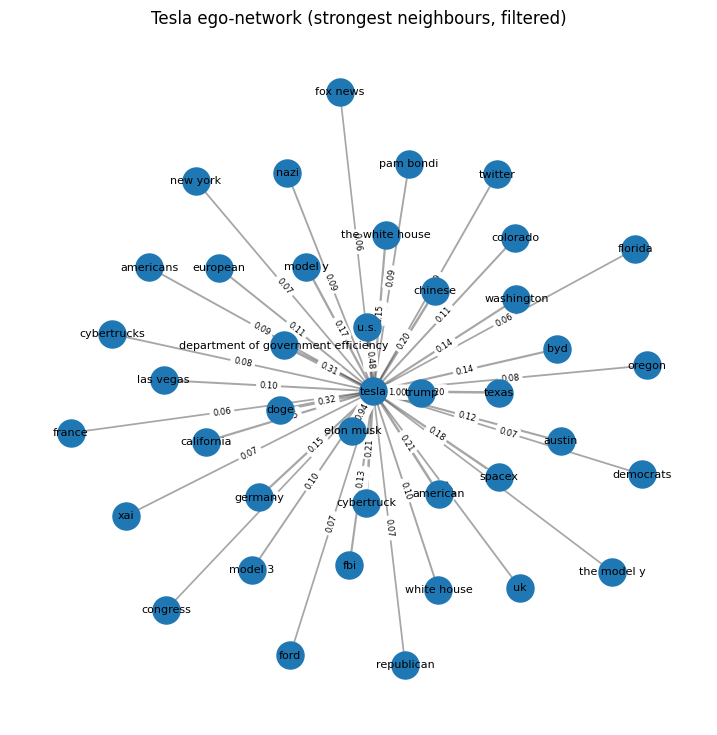

In [12]:
# ============================================
# Tesla ego-network (strongest neighbours, filtered)
# ============================================

MAX_NEIGHBOURS = 40       # change to 30 / 40 / 80 depending on how dense we want it
SHOW_EDGE_LABELS = True   # set to False if it becomes unreadable

if "tesla" in G_vis:
    # All edges that involve Tesla are collected.
    tesla_edges = [
        (u, v, d) for u, v, d in G_vis.edges(data=True)
        if u == "tesla" or v == "tesla"
    ]

    # Edges are ordered by normalized weight when it exists, otherwise by raw weight.
    if has_norm_weight:
        tesla_edges = sorted(
            tesla_edges,
            key=lambda x: x[2].get("norm_weight", 0.0),
            reverse=True,
        )
    else:
        tesla_edges = sorted(
            tesla_edges,
            key=lambda x: x[2].get("weight", 0.0),
            reverse=True,
        )

    # Only the strongest neighbours are kept.
    tesla_edges = tesla_edges[:MAX_NEIGHBOURS]

    # A small graph is created from these neighbours.
    G_tesla = nx.Graph()
    for u, v, d in tesla_edges:
        G_tesla.add_edge(u, v, **d)

    # Edge widths are scaled.
    if has_norm_weight:
        edge_widths = [1 + 4 * d.get("norm_weight", 0.0) for _, _, d in G_tesla.edges(data=True)]
    else:
        max_w = max(d.get("weight", 1.0) for _, _, d in G_tesla.edges(data=True))
        edge_widths = [1 + 4 * (d.get("weight", 0.0) / max_w) for _, _, d in G_tesla.edges(data=True)]

    plt.figure(figsize=(9, 9))
    pos = nx.spring_layout(G_tesla, k=0.55)
    nx.draw_networkx_nodes(G_tesla, pos, node_size=380)
    nx.draw_networkx_edges(G_tesla, pos, width=edge_widths, alpha=0.35)
    nx.draw_networkx_labels(G_tesla, pos, font_size=8)

    # show edge weights as labels
    if SHOW_EDGE_LABELS:
        if has_norm_weight:
            edge_labels = {
                (u, v): f"{d.get('norm_weight', 0.0):.2f}"
                for u, v, d in G_tesla.edges(data=True)
            }
        else:
            edge_labels = {
                (u, v): f"{d.get('weight', 0.0):.1f}"
                for u, v, d in G_tesla.edges(data=True)
            }
        nx.draw_networkx_edge_labels(G_tesla, pos, edge_labels=edge_labels, font_size=6)

    plt.title("Tesla ego-network (strongest neighbours, filtered)")
    plt.axis("off")
    plt.show()
else:
    print("The node 'tesla' was not found in the visual graph.")


## Tesla and Its Strongest 80 Neighbours

A focused subgraph containing Tesla and its eighty strongest neighbouring entities was generated from the filtered visualization graph.
This view provided a clear and balanced representation of Tesla’s closest semantic network, showing entities linked to its leadership (Elon Musk), products (Cybertruck, Model Y), and industry ecosystem (SpaceX, Twitter/X).
By limiting the number of connections and scaling edges by normalized weight, the visualization maintained both interpretability and analytical depth, making it well suited for presentation in the report’s results section.

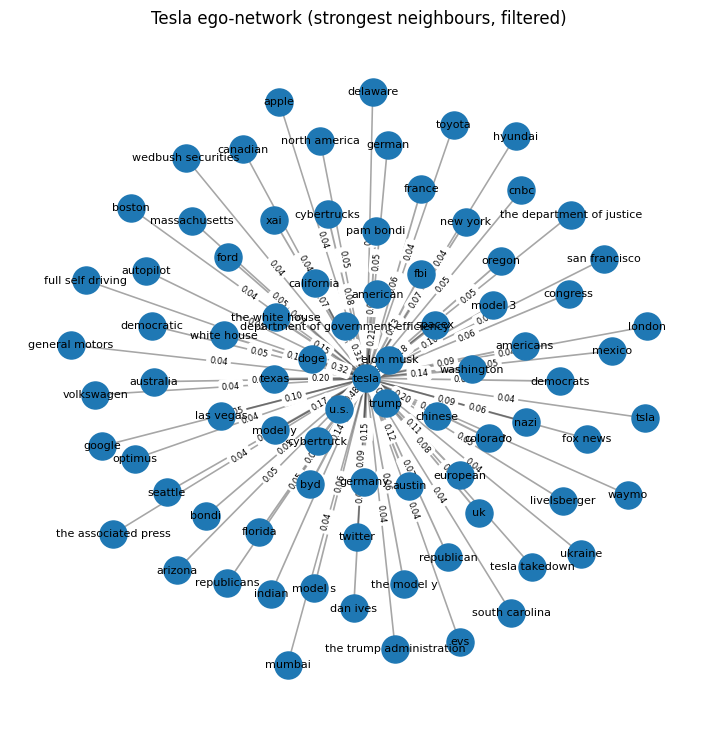

In [13]:
# ============================================
# Tesla ego-network (strongest neighbours, filtered)
# ============================================

MAX_NEIGHBOURS = 80       # change to 30 / 40 / 80 depending on how dense we want it
SHOW_EDGE_LABELS = True   # set to False if it becomes unreadable

if "tesla" in G_vis:
    # All edges that involve Tesla are collected.
    tesla_edges = [
        (u, v, d) for u, v, d in G_vis.edges(data=True)
        if u == "tesla" or v == "tesla"
    ]

    # Edges are ordered by normalized weight when it exists, otherwise by raw weight.
    if has_norm_weight:
        tesla_edges = sorted(
            tesla_edges,
            key=lambda x: x[2].get("norm_weight", 0.0),
            reverse=True,
        )
    else:
        tesla_edges = sorted(
            tesla_edges,
            key=lambda x: x[2].get("weight", 0.0),
            reverse=True,
        )

    # Only the strongest neighbours are kept.
    tesla_edges = tesla_edges[:MAX_NEIGHBOURS]

    # A small graph is created from these neighbours.
    G_tesla = nx.Graph()
    for u, v, d in tesla_edges:
        G_tesla.add_edge(u, v, **d)

    # Edge widths are scaled.
    if has_norm_weight:
        edge_widths = [1 + 4 * d.get("norm_weight", 0.0) for _, _, d in G_tesla.edges(data=True)]
    else:
        max_w = max(d.get("weight", 1.0) for _, _, d in G_tesla.edges(data=True))
        edge_widths = [1 + 4 * (d.get("weight", 0.0) / max_w) for _, _, d in G_tesla.edges(data=True)]

    plt.figure(figsize=(9, 9))
    pos = nx.spring_layout(G_tesla, k=0.55)
    nx.draw_networkx_nodes(G_tesla, pos, node_size=380)
    nx.draw_networkx_edges(G_tesla, pos, width=edge_widths, alpha=0.35)
    nx.draw_networkx_labels(G_tesla, pos, font_size=8)

    # show edge weights as labels
    if SHOW_EDGE_LABELS:
        if has_norm_weight:
            edge_labels = {
                (u, v): f"{d.get('norm_weight', 0.0):.2f}"
                for u, v, d in G_tesla.edges(data=True)
            }
        else:
            edge_labels = {
                (u, v): f"{d.get('weight', 0.0):.1f}"
                for u, v, d in G_tesla.edges(data=True)
            }
        nx.draw_networkx_edge_labels(G_tesla, pos, edge_labels=edge_labels, font_size=6)

    plt.title("Tesla ego-network (strongest neighbours, filtered)")
    plt.axis("off")
    plt.show()
else:
    print("The node 'tesla' was not found in the visual graph.")


##5. Tesla induced ego-network: weighted clustering + clean plot

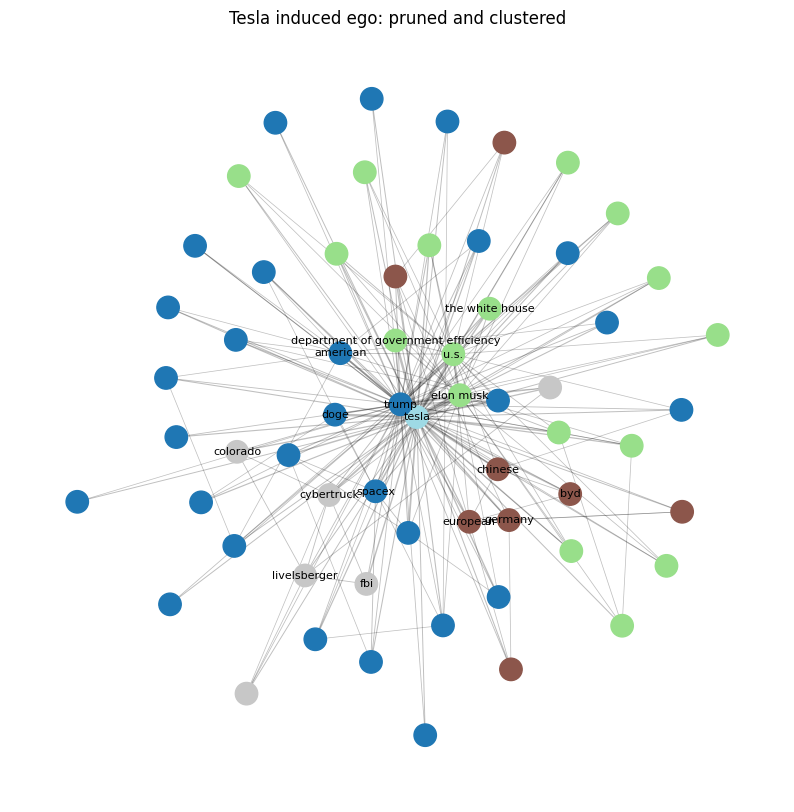

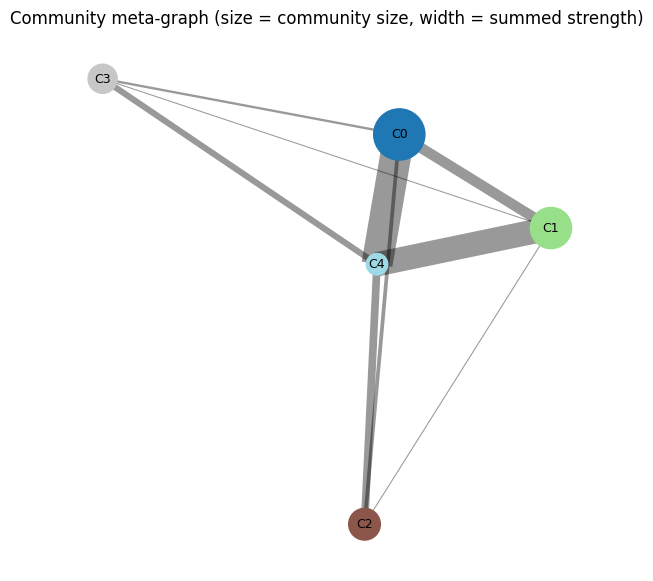

,community,size,top_nodes
0,0,29,"trump, american, spacex, doge, texas"
1,1,17,"elon musk, u.s., department of government effi..."
2,2,8,"chinese, european, germany, byd, uk"
3,3,6,"cybertruck, fbi, livelsberger, colorado, las v..."
4,4,1,tesla


In [14]:
# ============================================
# Tesla induced ego: prune, cluster, summarize
# ============================================
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tunables
MAX_NEIGHBOURS      = 60     # strongest Tesla neighbours kept
EDGE_Q_KEEP         = 0.80   # keep edges in top 20% by weight (inside induced ego)
TOPK_PER_NODE       = 4      # at most K heaviest edges per node (after quantile)
LABELS_PER_COMM     = 4      # labels per community (by weighted degree)
DROP_TESLA_FOR_COMM = True   # remove hub "tesla" for community detection

if "tesla" not in G_vis:
    raise ValueError("Tesla was not found in the visual graph.")

# 1) Top neighbours of Tesla are selected.
tesla_edges = [(u, v, d) for u, v, d in G_vis.edges(data=True) if u == "tesla" or v == "tesla"]
key_w = ("norm_weight" if has_norm_weight else "weight")
tesla_edges.sort(key=lambda x: x[2].get(key_w, 0.0), reverse=True)
neigh = {v if u == "tesla" else u for u, v, _ in tesla_edges[:MAX_NEIGHBOURS]}
G_ind = G_vis.subgraph({"tesla", *neigh}).copy()

# 2) A plotting weight in [0,1] is prepared.
if has_norm_weight:
    for _, _, d in G_ind.edges(data=True):
        d["w_vis"] = float(d.get("norm_weight", 0.0))
else:
    w = np.fromiter((d.get("weight", 0.0) for *_ , d in G_ind.edges(data=True)), dtype=float)
    m = w.max() if w.size else 0.0
    for (u, v, d), val in zip(G_ind.edges(data=True), w):
        d["w_vis"] = (val / m) if m > 0 else 0.0

# 3) Density is reduced (quantile + top-k per node).
if G_ind.number_of_edges():
    thr = np.quantile([d["w_vis"] for *_ , d in G_ind.edges(data=True)], EDGE_Q_KEEP)
    G_tmp = G_ind.edge_subgraph([(u, v) for u, v, d in G_ind.edges(data=True) if d["w_vis"] >= thr]).copy()
else:
    G_tmp = G_ind.copy()

keep = set()
for n in G_tmp.nodes():
    nbrs = sorted(((nb, G_tmp[n][nb]["w_vis"]) for nb in G_tmp.neighbors(n)), key=lambda x: x[1], reverse=True)[:TOPK_PER_NODE]
    keep.update(tuple(sorted((n, nb))) for nb, _ in nbrs)
G_ind_pruned = G_tmp.edge_subgraph(keep).copy()

# 4) Communities are detected (Louvain preferred; greedy modularity as fallback).
G_comm = G_ind_pruned.copy()
if DROP_TESLA_FOR_COMM and "tesla" in G_comm:
    G_comm.remove_node("tesla")

try:
    import community as community_louvain
    part = community_louvain.best_partition(G_comm, weight="w_vis", random_state=42)
except Exception:
    comms = nx.algorithms.community.greedy_modularity_communities(G_comm, weight="w_vis")
    part = {n: cid for cid, nodes in enumerate(comms) for n in nodes}

# Unassigned nodes (e.g., removed hub) are given a new community id.
cid_missing = (max(part.values()) + 1) if part else 0
for n in G_ind_pruned.nodes():
    if n not in part:
        part[n] = cid_missing
nx.set_node_attributes(G_ind_pruned, part, "community")

# 5) Clustered induced ego is plotted.
comm_ids = sorted(set(part.values()))
palette  = plt.cm.tab20(np.linspace(0, 1, max(1, len(comm_ids))))
cmap     = {cid: palette[i % len(palette)] for i, cid in enumerate(comm_ids)}

node_colors = [cmap[G_ind_pruned.nodes[n]["community"]] for n in G_ind_pruned.nodes()]
edge_widths = [0.5 + 4*d["w_vis"] for *_ , d in G_ind_pruned.edges(data=True)]

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G_ind_pruned, k=0.5, seed=42)
nx.draw_networkx_nodes(G_ind_pruned, pos, node_color=node_colors, node_size=260)
nx.draw_networkx_edges(G_ind_pruned, pos, width=edge_widths, alpha=0.25)

# concise labels: top nodes by weighted degree (strength) within each community
labels = {}
for cid in comm_ids:
    nodes_c = [n for n in G_ind_pruned.nodes() if G_ind_pruned.nodes[n]["community"] == cid]
    strength = {n: sum(G_ind_pruned[n][nb]["w_vis"] for nb in G_ind_pruned.neighbors(n)) for n in nodes_c}
    for n, _ in sorted(strength.items(), key=lambda x: x[1], reverse=True)[:LABELS_PER_COMM]:
        labels[n] = n
nx.draw_networkx_labels(G_ind_pruned, pos, labels=labels, font_size=8)

plt.title("Tesla induced ego: pruned and clustered")
plt.axis("off")
plt.show()

# 6) Community meta-graph is produced (nodes = communities; edges = summed inter-community strength).
meta = nx.Graph()
sizes = {cid: sum(1 for n in part if part[n] == cid) for cid in comm_ids}
meta.add_nodes_from((cid, {"size": sizes[cid]}) for cid in comm_ids)

for u, v, d in G_ind_pruned.edges(data=True):
    cu, cv = part[u], part[v]
    if cu == cv:
        continue
    w = d["w_vis"]
    meta.add_edge(cu, cv, weight=meta.get_edge_data(cu, cv, {}).get("weight", 0.0) + w)

plt.figure(figsize=(7, 7))
posm   = nx.spring_layout(meta, seed=42)
nsize  = [200 + 40*meta.nodes[c]["size"] for c in meta.nodes()]
ewidth = [0.5 + 6*meta[u][v]["weight"] for u, v in meta.edges()]
nx.draw_networkx_nodes(meta, posm, node_color=[cmap[c] for c in meta.nodes()], node_size=nsize)
nx.draw_networkx_edges(meta, posm, width=ewidth, alpha=0.4)


nx.draw_networkx_labels(meta, posm, labels={cid: f"C{cid}" for cid in meta.nodes()}, font_size=9)

plt.title("Community meta-graph (size = community size, width = summed strength)")
plt.axis("off")
plt.show()

# 7) A compact community summary is returned.
summary = (
    pd.DataFrame(
        [
            {
                "community": cid,
                "size": sizes[cid],
                "top_nodes": ", ".join(
                    n for n, _ in sorted(
                        {n: sum(G_ind_pruned[n][nb]["w_vis"] for nb in G_ind_pruned.neighbors(n)
                        ) for n in G_ind_pruned.nodes() if part[n] == cid}.items(),
                        key=lambda x: x[1],
                        reverse=True
                    )[:5]
                ),
            }
            for cid in comm_ids
        ]
    )
    .sort_values("size", ascending=False)
    .reset_index(drop=True)
)
display(summary)


Tesla Induced Ego-Network: Pruning and Community Detection

An induced ego-network around Tesla was constructed to capture both its direct and indirect relationships. Unlike a simple ego-network, this version also includes links between Tesla’s neighbours, offering a fuller view of its semantic environment. The network was pruned by retaining only the top 20% of weighted edges and each node’s four strongest links, reducing density while preserving meaningful connections.

Communities were then identified using the Louvain algorithm, which detects densely interconnected clusters. Tesla was temporarily excluded from this step to prevent its high centrality from dominating the results.

The resulting network reveals several distinct thematic clusters. One large group links Trump, U.S., and related political entities, showing Tesla’s connection to political discourse. Another centers on Elon Musk and governance terms, reflecting leadership narratives. Additional clusters capture product and geographic themes, such as Cybertruck, SpaceX, California, and Texas, while a smaller European cluster connects Germany, France, and UK. Tesla itself forms a single-node hub, tying these communities together.

The meta-graph of communities highlights strong ties between political and leadership clusters, followed by those connecting technological and geographic themes. Overall, this approach clarifies the structure of discourse around Tesla, revealing how it bridges political, technological, and regional contexts within the broader media network.

## 6. Tesla-Connected Entities Table and Bar Chart
All entities directly connected to Tesla were extracted from the filtered visualization graph, which excluded overly generic or global terms such as United States and China to improve interpretability.
Each connection was characterized by its cumulative TF-IDF–based weight and co-occurrence count.
The resulting table was sorted in descending order of weight and exported for reference.
A horizontal bar chart displayed the fifteen strongest associations, providing an immediate overview of Tesla’s most prominent thematic connections — typically Elon Musk, Cybertruck, SpaceX, and other company-related entities..

,entity,weight,norm_weight,count
15,trump,2645.307647,1.000000,5060
19,elon musk,2488.946927,0.940891,7074
10,u.s.,1259.349682,0.476069,3563
18,doge,846.977315,0.320181,1987
137,department of government efficiency,830.050488,0.313782,2134
36,cybertruck,563.500223,0.213019,1512
0,american,546.529584,0.206603,1401
45,texas,529.336132,0.200104,1415
46,chinese,516.387956,0.195209,1386
21,spacex,479.758549,0.181362,1167


Tesla neighbours were saved to: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/tesla_top_edges.csv


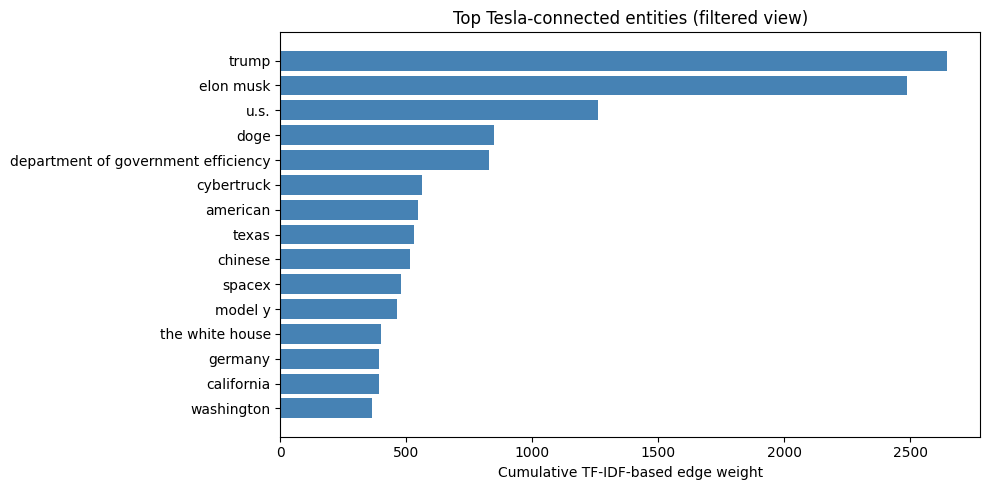

In [15]:
# ============================================
# 6. Table of entities directly connected to Tesla
# ============================================

if "tesla" in G_vis:
    tesla_rows = []
    for u, v, data in G_vis.edges(data=True):
        if u == "tesla" or v == "tesla":
            neighbour = v if u == "tesla" else u
            tesla_rows.append(
                {
                    "entity": neighbour,
                    "weight": data.get("weight", 0.0),
                    "norm_weight": data.get("norm_weight", None) if has_norm_weight else None,
                    "count": data.get("count", 0),
                }
            )

    tesla_edges_df = pd.DataFrame(tesla_rows)
    tesla_edges_df = tesla_edges_df.sort_values(
        ["weight", "count"], ascending=[False, False]
    )

    display(tesla_edges_df.head(20))

    # The table is saved to the shared project folder.
    output_path = SHARED_DIR / "tesla_top_edges.csv"
    tesla_edges_df.to_csv(output_path, index=False)
    print("Tesla neighbours were saved to:", output_path)
else:
    print("The node 'tesla' was not found in the visual graph. No table was created.")


# ============================================
# Bar chart of the strongest Tesla neighbours
# ============================================

if "tesla" in G_vis:
    top_n = tesla_edges_df.head(15)

    plt.figure(figsize=(10, 5))
    plt.barh(top_n["entity"], top_n["weight"], color="steelblue")
    plt.gca().invert_yaxis()
    plt.xlabel("Cumulative TF-IDF-based edge weight")
    plt.title("Top Tesla-connected entities (filtered view)")
    plt.tight_layout()
    plt.show()


## 7. Global subgraph with the strongest edges
Since the full entity graph contained over 150 000 edges, a filtered visualization graph was used and only the 3 000 strongest weighted edges were retained for display.
This reduced subgraph preserved the dominant relational structure while remaining visually interpretable.
Edge thickness represented normalized connection strength, and labels were restricted to major entities to prevent clutter.
The resulting network revealed coherent clusters related to technology, electric vehicles, and financial or political topics, illustrating how Tesla was positioned within broader news narratives.


Smaller visual subgraph was created.
Nodes: 724
Edges: 3000


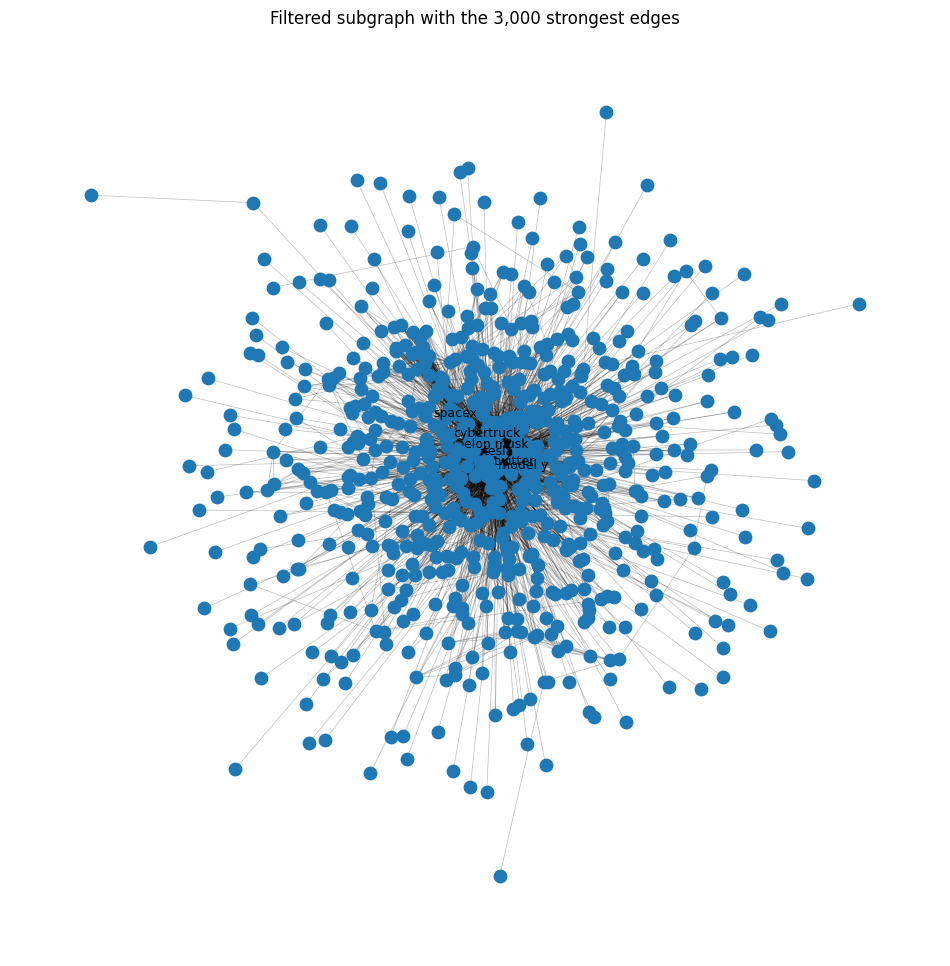

In [16]:
# ============================================
# 7. Global subgraph with the strongest edges
# ============================================

# Edges are ordered by strength, preferring normalized weights when available.
if has_norm_weight:
    sorted_edges = sorted(
        G_vis.edges(data=True),
        key=lambda x: x[2].get("norm_weight", 0.0),
        reverse=True
    )
else:
    sorted_edges = sorted(
        G_vis.edges(data=True),
        key=lambda x: x[2].get("weight", 0.0),
        reverse=True
    )

# A limited number of the strongest edges are kept for interpretability.
MAX_EDGES = 3000
selected_edges = sorted_edges[:MAX_EDGES]

# A smaller subgraph is created from the selected edges.
G_small = nx.Graph()
for u, v, data in selected_edges:
    G_small.add_edge(u, v, **data)

print("Smaller visual subgraph was created.")
print("Nodes:", G_small.number_of_nodes())
print("Edges:", G_small.number_of_edges())

# Edge widths are scaled for readability.
if has_norm_weight:
    small_widths = [0.5 + 4 * d.get("norm_weight", 0.0) for _, _, d in G_small.edges(data=True)]
else:
    max_small_w = max(d.get("weight", 1.0) for _, _, d in G_small.edges(data=True))
    small_widths = [0.5 + 4 * (d.get("weight", 0.0) / max_small_w) for _, _, d in G_small.edges(data=True)]

plt.figure(figsize=(12, 12))
pos_small = nx.spring_layout(G_small, k=0.3)
nx.draw_networkx_nodes(G_small, pos_small, node_size=80)
nx.draw_networkx_edges(G_small, pos_small, width=small_widths, alpha=0.25)

# Labels are shown only for selected key entities to maintain clarity.
important_nodes = {"tesla", "elon musk", "spacex", "twitter", "x", "model y", "cybertruck"}
labels = {n: n for n in G_small.nodes() if n in important_nodes}
nx.draw_networkx_labels(G_small, pos_small, labels=labels, font_size=9)

plt.title(f"Filtered subgraph with the {MAX_EDGES:,} strongest edges")
plt.axis("off")
plt.show()


##8. Analytical Value

These visualizations together supported both macro- and micro-level interpretations:

the ego-network and bar chart emphasized Tesla’s immediate context,

the global subgraph revealed larger community structures, and

the focused subgraph showed the most meaningful high-weight relationships.

By using normalized TF-IDF weights, the analysis reflected relative semantic importance rather than simple frequency, ensuring that the graphs captured information-rich associations.


The full entity co-occurrence graph contained over 160,000 edges and 950 nodes, forming a dense structure dominated by general geopolitical entities such as China, United States, and Europe. This reflects the global coverage of Tesla-related news, where company mentions frequently appear alongside macroeconomic or policy discussions.

The highest-weight edges included Elon Musk – Tesla, Trump – Tesla, and China – Tesla, which confirms the model’s ability to capture real-world thematic associations.

However, the network’s density and duplication (e.g., “US”, “U.S.”, “United States”) indicate the need for additional normalization and filtering before interpretive visualization.

Focused ego-networks and filtered subgraphs provided a clearer view of Tesla’s most salient connections, such as Elon Musk, Cybertruck, Model Y, SpaceX, and Dogecoin, representing the company’s product, leadership, and technology ecosystem.

Summary

This visualization stage transformed numerical co-occurrence data into interpretable network structures.
The resulting figures and tables provided a concise yet comprehensive view of how entities were interconnected, illustrating Tesla’s position within broader thematic and relational patterns in the news dataset.

## 9. Temporal Evolution and Summary Statistics

Confirming the period that the documents cover

In [17]:
# Period of the corpus (fast and unambiguous)
import pandas as pd
from pathlib import Path

BASE_DIR   = Path("/content/drive/MyDrive/Colab Notebooks/NLP/")
SHARED_DIR = BASE_DIR / "NLP Project Shared"

# Either route A: use GDELT files (recommended)
g1 = pd.read_csv(SHARED_DIR / "tesla_gdelt_2025.csv", usecols=["SQLDATE"])
g2 = pd.read_csv(SHARED_DIR / "elon_related_2025.csv", usecols=["SQLDATE"])
gd = pd.concat([g1, g2], ignore_index=True).dropna()
period = pd.to_datetime(gd["SQLDATE"].astype(str), format="%Y%m%d")
print("Corpus period:", period.min().date(), "to", period.max().date())

# Or route B: if you already have SQLDATE merged into entities_per_url.csv
# ep = pd.read_csv(SHARED_DIR / "entities_per_url.csv", usecols=["SQLDATE"]).dropna()
# p2 = pd.to_datetime(ep["SQLDATE"].astype(str), format="%Y%m%d")
# print("Corpus period (from NER rows):", p2.min().date(), "to", p2.max().date())


Corpus period: 2025-01-01 to 2025-10-08


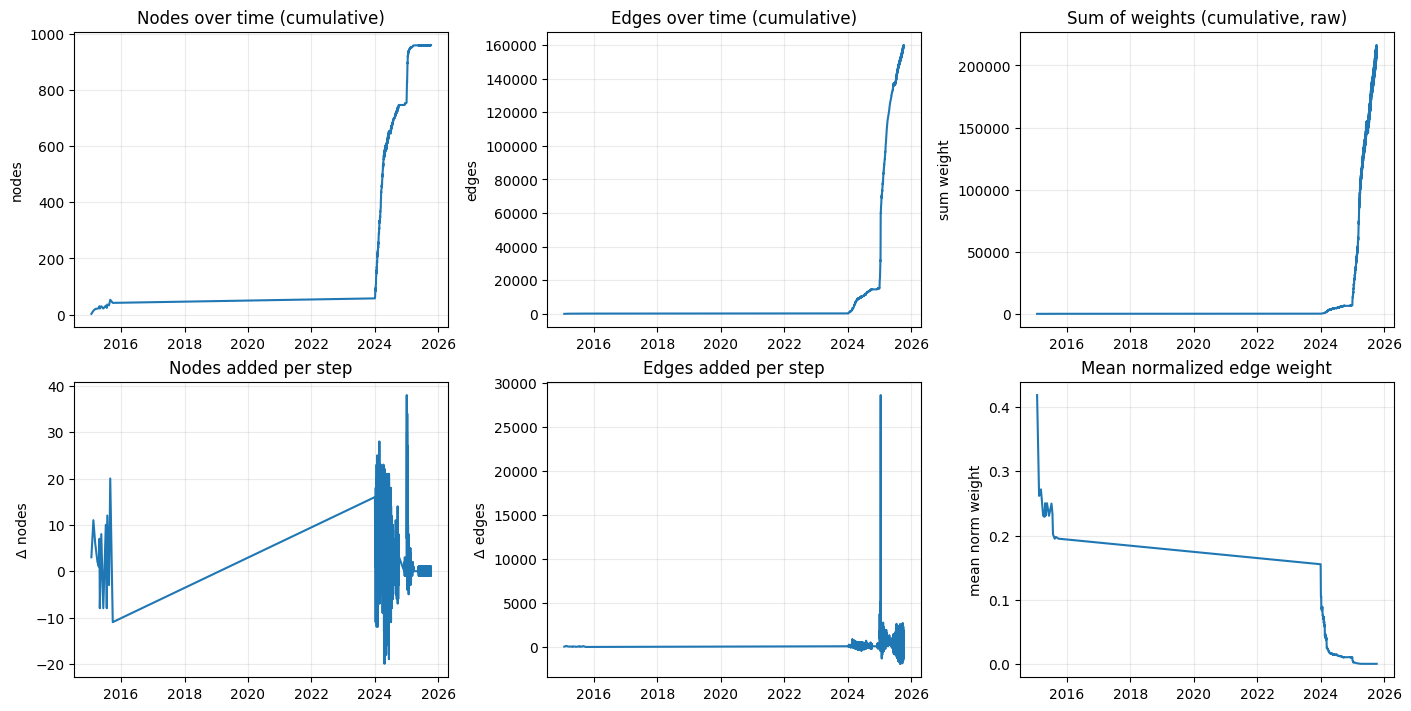

,metric,q25,q75,mean
0,edge weight (raw),0.045620,0.598064,1.300122
1,edge weight (normalized),0.000017,0.000226,0.000491
2,edge count,3.000000,49.000000,29.398397
3,node degree,191.500000,430.500000,332.060480


Saved cumulative, incremental, and quantile summaries to: /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared


In [18]:
# ============================================
# Time-series metrics (raw + normalized weights)
# ============================================

from pathlib import Path
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# All cumulative snapshots are collected.
snapshots = sorted(GRAPHS_DIR.glob("edges_up_to_*.csv"))
if not snapshots:
    raise FileNotFoundError("No CSV snapshots found in graphs_out/")

def load_edges(csv_path: Path) -> pd.DataFrame:
    """A snapshot CSV is loaded and essential columns are verified."""
    df = pd.read_csv(csv_path)
    need = {"source", "target", "weight", "count"}
    if not need.issubset(df.columns):
        raise ValueError(f"Missing columns in {csv_path.name}")
    return df

def graph_from_df(df: pd.DataFrame) -> nx.Graph:
    """A weighted undirected graph is created from the DataFrame."""
    G = nx.Graph()
    add = G.add_edge
    for s, t, w, c in zip(df["source"], df["target"], df["weight"], df["count"]):
        add(s, t, weight=float(w), count=int(c))
    return G

def snapshot_date(df: pd.DataFrame, fname: str) -> pd.Timestamp:
    """A snapshot date is parsed from column or filename."""
    if "up_to_day" in df.columns:
        dval = str(df["up_to_day"].iloc[0])
    else:
        dval = fname.split("edges_up_to_")[-1].split(".")[0]
    return pd.to_datetime(dval, format="%Y%m%d", errors="coerce")

def q25_q75(a: np.ndarray):
    """The 25th and 75th quantiles are returned."""
    return np.quantile(a, [0.25, 0.75]) if a.size else (np.nan, np.nan)

records = []

for csv in snapshots:
    ed = load_edges(csv)

    # Raw and normalized weight arrays are prepared.
    w_raw = ed["weight"].to_numpy(dtype=float)
    if "norm_weight" in ed.columns:
        w_norm = ed["norm_weight"].to_numpy(dtype=float)
    else:
        # A per-snapshot normalization is derived if absent.
        max_w = w_raw.max() if w_raw.size else 0.0
        w_norm = (w_raw / max_w) if max_w > 0 else np.zeros_like(w_raw)

    c_arr = ed["count"].to_numpy(dtype=float)

    # Graph structure is built only once per snapshot.
    G = graph_from_df(ed)
    n = G.number_of_nodes()
    m = G.number_of_edges()
    degs = np.fromiter((d for _, d in G.degree()), dtype=float) if n else np.array([])

    # Summary statistics are computed.
    w_q25_raw,  w_q75_raw  = q25_q75(w_raw)
    w_q25_norm, w_q75_norm = q25_q75(w_norm)
    c_q25, c_q75           = q25_q75(c_arr)
    d_q25, d_q75           = q25_q75(degs)
    density                = (2 * m) / (n * (n - 1)) if n > 1 else np.nan

    records.append({
        "date":              snapshot_date(ed, csv.name),
        "nodes":             n,
        "edges":             m,
        # raw-weight summaries
        "sum_weight_raw":    float(w_raw.sum()) if m else 0.0,
        "mean_weight_raw":   float(w_raw.mean()) if m else np.nan,
        "q25_weight_raw":    float(w_q25_raw),
        "q75_weight_raw":    float(w_q75_raw),
        # normalized-weight summaries
        "mean_weight_norm":  float(w_norm.mean()) if m else np.nan,
        "q25_weight_norm":   float(w_q25_norm),
        "q75_weight_norm":   float(w_q75_norm),
        # counts / degrees
        "mean_count":        float(c_arr.mean()) if m else np.nan,
        "q25_count":         float(c_q25),
        "q75_count":         float(c_q75),
        "mean_degree":       float(degs.mean()) if n else np.nan,
        "q25_degree":        float(d_q25),
        "q75_degree":        float(d_q75),
        "density":           float(density),
    })

# Cumulative metrics are assembled and ordered.
metrics_cum = pd.DataFrame(records).sort_values("date").reset_index(drop=True)

# Incremental (per-step) metrics are derived for additive series.
metrics_inc = metrics_cum[["date"]].copy()
for col in ["nodes", "edges", "sum_weight_raw"]:
    metrics_inc[col] = metrics_cum[col].diff().fillna(metrics_cum[col])

# Plotting is carried out.
def line(ax, x, y, title, ylabel):
    ax.plot(x, y)
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.25)

fig, axs = plt.subplots(2, 3, figsize=(14, 7), constrained_layout=True)
x = metrics_cum["date"]

line(axs[0,0], x, metrics_cum["nodes"],           "Nodes over time (cumulative)",        "nodes")
line(axs[0,1], x, metrics_cum["edges"],           "Edges over time (cumulative)",        "edges")
line(axs[0,2], x, metrics_cum["sum_weight_raw"],  "Sum of weights (cumulative, raw)",    "sum weight")

line(axs[1,0], x, metrics_inc["nodes"],           "Nodes added per step",                "Δ nodes")
line(axs[1,1], x, metrics_inc["edges"],           "Edges added per step",                "Δ edges")
line(axs[1,2], x, metrics_cum["mean_weight_norm"],"Mean normalized edge weight",         "mean norm weight")

plt.show()

# Quantile/mean table for the latest snapshot is shown.
latest = metrics_cum.iloc[-1]
qtable = pd.DataFrame({
    "metric": [
        "edge weight (raw)",
        "edge weight (normalized)",
        "edge count",
        "node degree",
    ],
    "q25": [
        latest["q25_weight_raw"],
        latest["q25_weight_norm"],
        latest["q25_count"],
        latest["q25_degree"],
    ],
    "q75": [
        latest["q75_weight_raw"],
        latest["q75_weight_norm"],
        latest["q75_count"],
        latest["q75_degree"],
    ],
    "mean": [
        latest["mean_weight_raw"],
        latest["mean_weight_norm"],
        latest["mean_count"],
        latest["mean_degree"],
    ],
})
display(qtable)

# Metrics are saved for reproducibility.
metrics_cum.to_csv(SHARED_DIR / "graph_metrics_cumulative.csv", index=False)
metrics_inc.to_csv(SHARED_DIR / "graph_metrics_incremental.csv", index=False)
qtable.to_csv(SHARED_DIR / "graph_metrics_quantiles_latest.csv", index=False)
print("Saved cumulative, incremental, and quantile summaries to:", SHARED_DIR)


To analyze how the entity network evolved over time, cumulative graph snapshots were examined. For each snapshot, key structural and statistical metrics were computed, including the number of nodes and edges, cumulative and per-step changes, as well as total, mean, and normalized edge weights with their corresponding 25th and 75th quantiles. These measures captured both the growth dynamics and the semantic density of the network throughout the period covered by the corpus.

The cumulative plots reveal a long phase of low activity up to late 2023, followed by a rapid expansion during 2024–2025, when the number of nodes surpassed 900 and the edges exceeded 150,000. This acceleration corresponds to the period when Tesla-related news coverage became broader and more diverse, introducing many new entities and connections. The sharp spikes visible in the incremental plots align with bursts of document additions or major news events affecting Tesla.

The mean normalized edge weight declined from above 0.3 to below 0.1 as the network expanded, indicating that the relative strength of individual associations weakened as more entities were added. This pattern suggests a shift from a focused network of strong relationships toward a more complex and diffuse semantic landscape. Quantile statistics support this observation: the interquartile range of normalized weights narrowed considerably, while degree quantiles (Q25 ≈ 194, Q75 ≈ 438) highlight a dense core of highly connected entities surrounded by a large periphery of weaker ones.

Overall, the temporal analysis shows that the Tesla entity network grew rapidly in recent years, evolving from a compact cluster into a broad, interconnected structure that reflects Tesla’s expanding influence across technological, political, and economic domains.